In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as nnf
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from torchinfo import summary

from utils.datasets import MNIST_SR, MNIST_SR2

from tqdm import tqdm

import matplotlib.pyplot as plt

from models.prediction.VAE import VAE
from models.prediction.HVAE import HVAE

from utils.metrics import validation_scores

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
x_dim = 32

scale_factor = 4
x_inp_dim  = int(x_dim / scale_factor)


# # hidden_dim = 500
latent_dim = 20

# lr = 1e-3
epochs = 100
batch_size = 2048
batch_size_test = 128

train_dataset = MNIST_SR(split="train", scale_factor=scale_factor)
test_dataset = MNIST_SR(split="test", scale_factor=scale_factor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [3]:
path = "MNIST_VAE_divers.pth"

in_channels = 1
channels = [16, 32, 64, 128]
latent_dims = [20]

vae_model = VAE(in_channels=in_channels, channels=channels, latent_dims=latent_dims, base_width=x_inp_dim).to(DEVICE)
vae_model.load_state_dict(torch.load(path))
summary(vae_model, input_size=(1,in_channels, x_inp_dim, x_inp_dim))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 1, 32, 32]            --
├─VAELREncoder: 1-1                      [1, 20]                   --
│    └─Conv2d: 2-1                       [1, 16, 8, 8]             32
│    └─Conv2d: 2-2                       [1, 32, 4, 4]             8,224
│    └─Conv2d: 2-3                       [1, 64, 2, 2]             32,832
│    └─Linear: 2-4                       [1, 20]                   5,140
│    └─Linear: 2-5                       [1, 20]                   5,140
├─VAEDecoder: 1-2                        [1, 1, 32, 32]            --
│    └─Linear: 2-6                       [1, 2048]                 43,008
│    └─ConvTranspose2d: 2-7              [1, 64, 8, 8]             131,136
│    └─ConvTranspose2d: 2-8              [1, 32, 16, 16]           32,800
│    └─ConvTranspose2d: 2-9              [1, 16, 32, 32]           8,208
│    └─Conv2d: 2-10                      [1, 1, 32, 32] 

In [4]:
path = "MNIST_HVAE_divers.pth"

in_channels = 1
channels = [16, 32, 64, 128]
latent_dims = [8,8,8]

hvae_model = HVAE(in_channels=in_channels, channels=channels, latent_dims=latent_dims, base_width=x_inp_dim).to(DEVICE)
hvae_model.load_state_dict(torch.load(path))
summary(hvae_model, input_size=(1,in_channels, x_inp_dim, x_inp_dim))

Layer (type:depth-idx)                   Output Shape              Param #
HVAE                                     [1, 1, 32, 32]            --
├─HVAELREncoder: 1-1                     [1, 8]                    --
│    └─Conv2d: 2-1                       [1, 16, 8, 8]             32
│    └─Conv2d: 2-2                       [1, 32, 4, 4]             8,224
│    └─Conv2d: 2-3                       [1, 64, 2, 2]             32,832
│    └─Linear: 2-4                       [1, 8]                    2,056
│    └─Linear: 2-5                       [1, 8]                    2,056
│    └─Linear: 2-6                       [1, 8]                    4,104
│    └─Linear: 2-7                       [1, 8]                    4,104
│    └─Linear: 2-8                       [1, 8]                    8,200
│    └─Linear: 2-9                       [1, 8]                    8,200
├─Linear: 1-2                            [1, 8]                    72
├─Linear: 1-3                            [1, 8]             

In [5]:
test_dataset = MNIST_SR2(split="test", scale_factor=scale_factor)

In [ ]:
HR, LR, labels = test_dataset.get_samples(10000)
labels = np.array(labels)
SR_vae = vae_model.sample(LR)
SR_hvae = hvae_model.sample(LR)

AttributeError: 'list' object has no attribute 'numpy'

In [16]:
print(labels)

[7 2 1 ... 4 5 6]


In [19]:
for i in range(10):
    HR_i = HR[labels == i]
    LR_i = LR[labels == i]
    mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(vae_model, HR_i, LR_i)
    print("Class:", i)
    print("MSE:", mse_val)
    print("Perceptual:", perceptual_val)
    print("PSNR:", psnr_val)
    print("SSIM:", ssim_val)
    print("LPIPS:", lpips_val)
    print("BRISQUE:", brisque_val)
    print("PSNR Consistency:", psnr_consistency_val)
    print("MSE Diversity:", mse_diversity_val)
    print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class: 0
MSE: 0.0069297426380217075
Perceptual: 1.5369514226913452
PSNR: 22.00330924987793
SSIM: 0.9086400270462036
LPIPS: 0.06669257581233978
BRISQUE: 64.50676727294922
PSNR Consistency: 30.9446964263916
MSE Diversity: 0.0020034903075156762
LPIPS Diversity: 0.008903509276933619
Class: 1
MSE: 0.0024019419215619564
Perceptual: 0.7840275168418884
PSNR: 26.728464126586914
SSIM: 0.9486759901046753
LPIPS: 0.04627969488501549
BRISQUE: 98.98226928710938
PSNR Consistency: 35.967994689941406
MSE Diversity: 0.0014861391960039327
LPIPS Diversity: 0.021319873976608505
Class: 2
MSE: 0.009509383700788021
Perceptual: 1.8862967491149902
PSNR: 20.610301971435547
SSIM: 0.851460874080658
LPIPS: 0.07403747737407684
BRISQUE: 68.71493530273438
PSNR Consistency: 29.84200096130371
MSE Diversity: 0.0021241230883788376
LPIPS Diversity: 0.015792123918799916
Class: 3
MSE: 0.008601421490311623
Perceptual: 1.4998023509979248
PSNR: 21.0318660736084
SSIM: 0.8538435101509094
LPIPS: 0.06061039865016937
BRISQUE: 67.4020

In [20]:
for i in range(10):
    HR_i = HR[labels == i]
    LR_i = LR[labels == i]
    mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(hvae_model, HR_i, LR_i)
    print("Class:", i)
    print("MSE:", mse_val)
    print("Perceptual:", perceptual_val)
    print("PSNR:", psnr_val)
    print("SSIM:", ssim_val)
    print("LPIPS:", lpips_val)
    print("BRISQUE:", brisque_val)
    print("PSNR Consistency:", psnr_consistency_val)
    print("MSE Diversity:", mse_diversity_val)
    print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class: 0
MSE: 0.007444663438946009
Perceptual: 1.5351284742355347
PSNR: 21.62866973876953
SSIM: 0.8997488021850586
LPIPS: 0.06689706444740295
BRISQUE: 67.12625885009766
PSNR Consistency: 30.203781127929688
MSE Diversity: 0.0025194654740516853
LPIPS Diversity: 0.01357676897168858
Class: 1
MSE: 0.0027878661639988422
Perceptual: 0.8008280396461487
PSNR: 26.02024269104004
SSIM: 0.9393882155418396
LPIPS: 0.045439522713422775
BRISQUE: 97.79013061523438
PSNR Consistency: 34.963897705078125
MSE Diversity: 0.0019380062065010861
LPIPS Diversity: 0.026104905802640133
Class: 2
MSE: 0.010216748341917992
Perceptual: 1.9984897375106812
PSNR: 20.228837966918945
SSIM: 0.8359682559967041
LPIPS: 0.08277985453605652
BRISQUE: 67.92608642578125
PSNR Consistency: 29.136837005615234
MSE Diversity: 0.0027814132899948163
LPIPS Diversity: 0.021421748042484978
Class: 3
MSE: 0.009307441301643848
Perceptual: 1.6271835565567017
PSNR: 20.613414764404297
SSIM: 0.8391540050506592
LPIPS: 0.0677323043346405
BRISQUE: 70.7

In [6]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
        axs[2, i].axis('off')

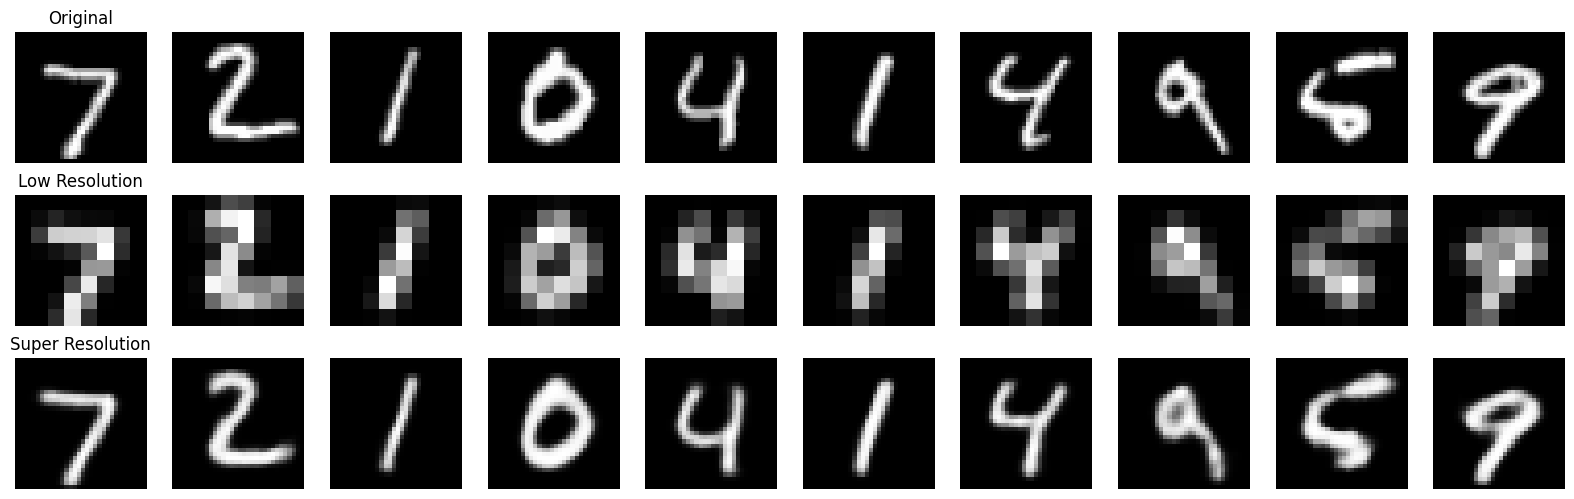

In [7]:
show_image(HR, LR, SR_vae, 10)

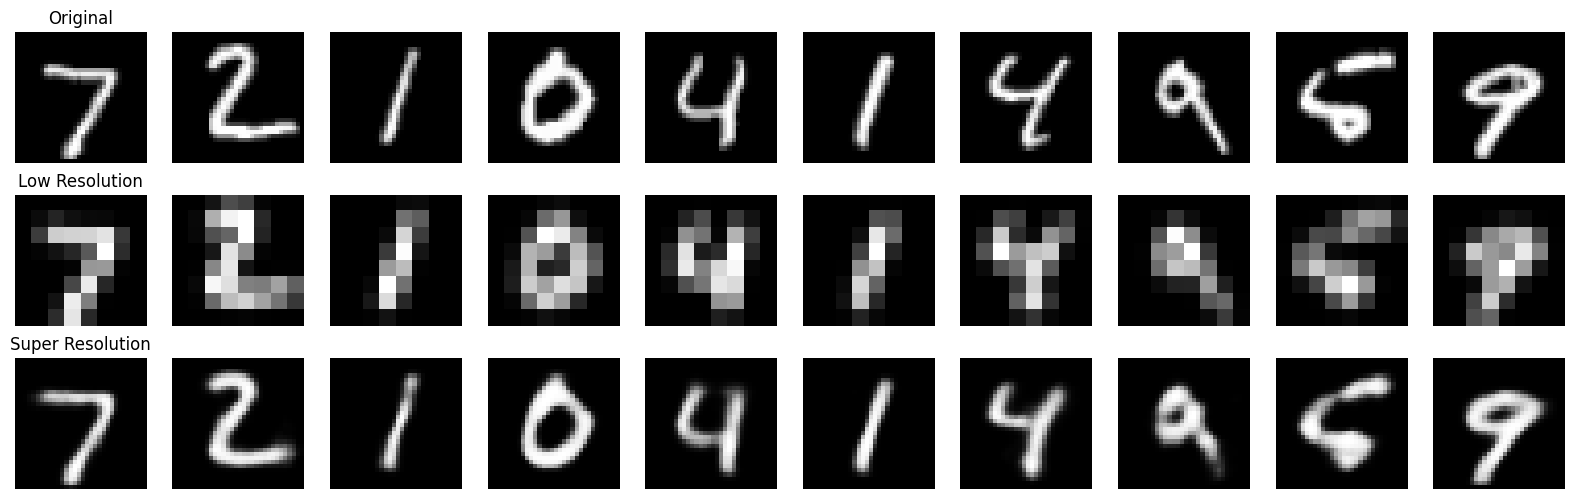

In [8]:
show_image(HR, LR, SR_hvae, 10)

C:\Users\maxhe\AppData\Local\Temp\ipykernel_16604\3805114516.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, n, figsize=(20, 6))


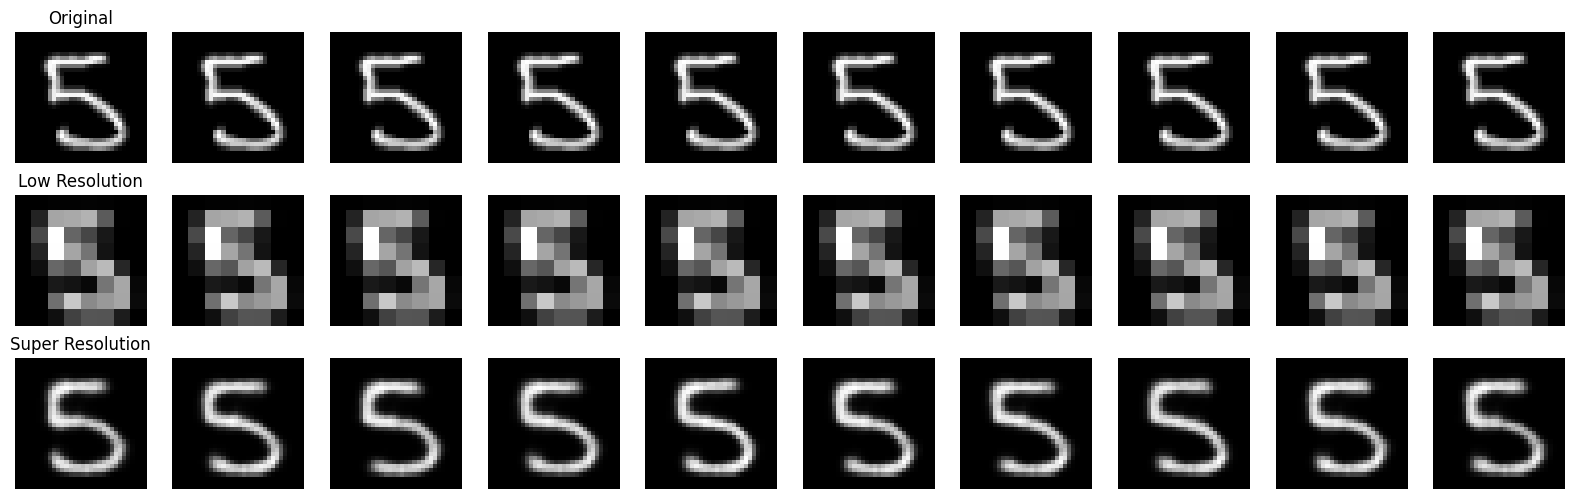

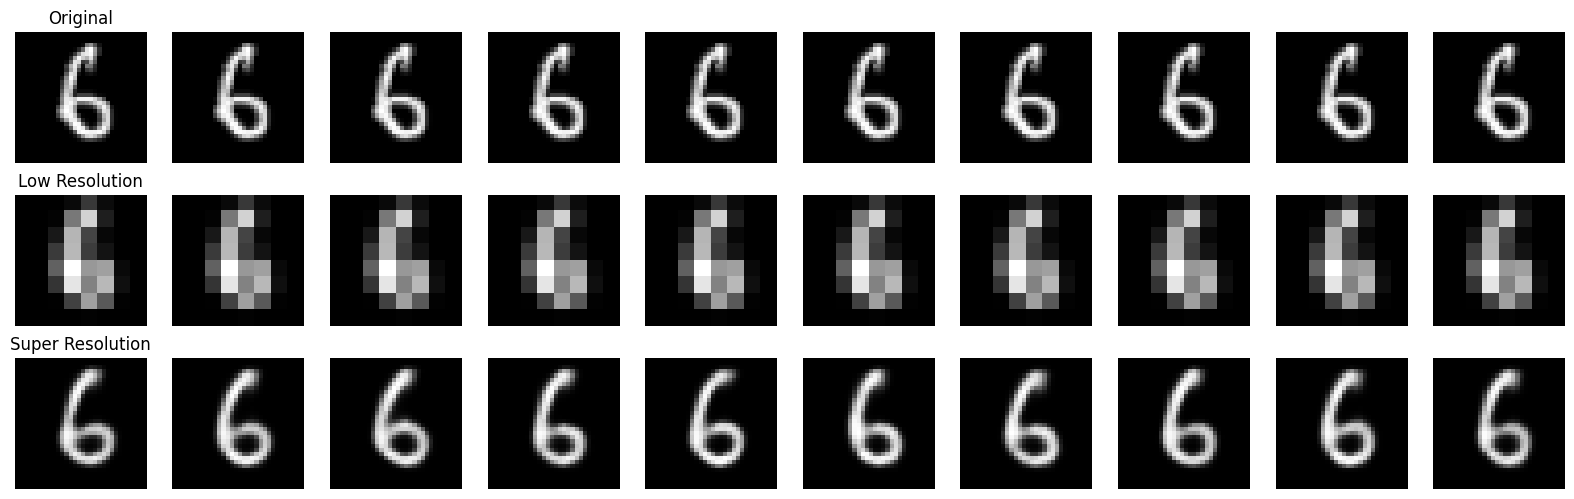

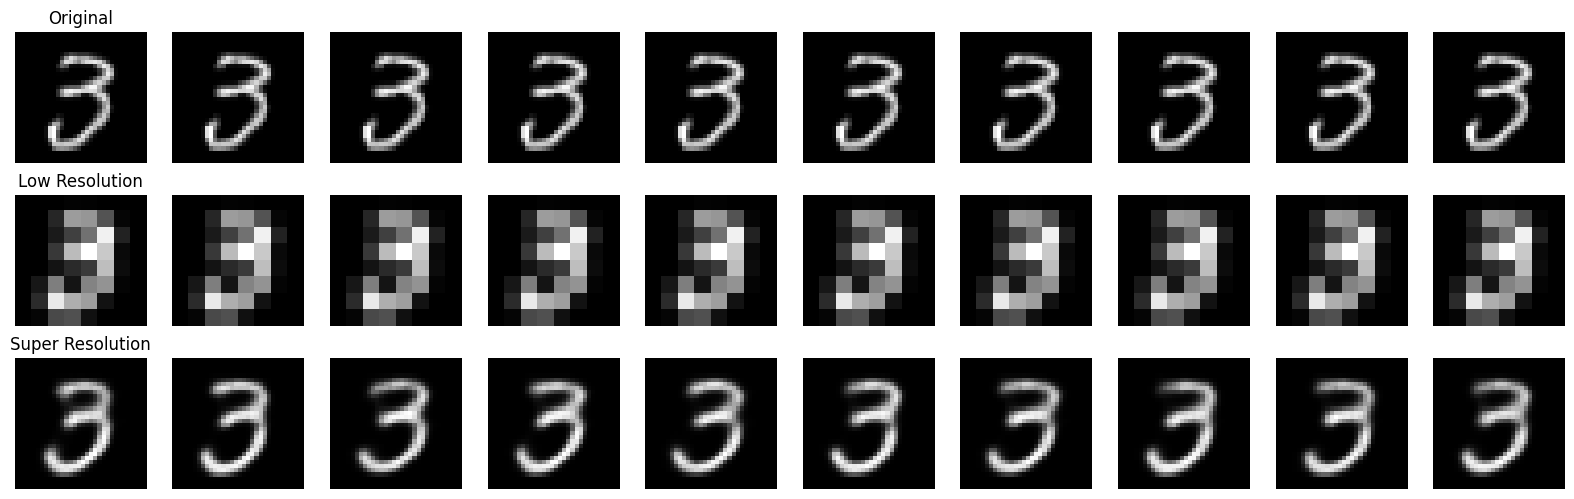

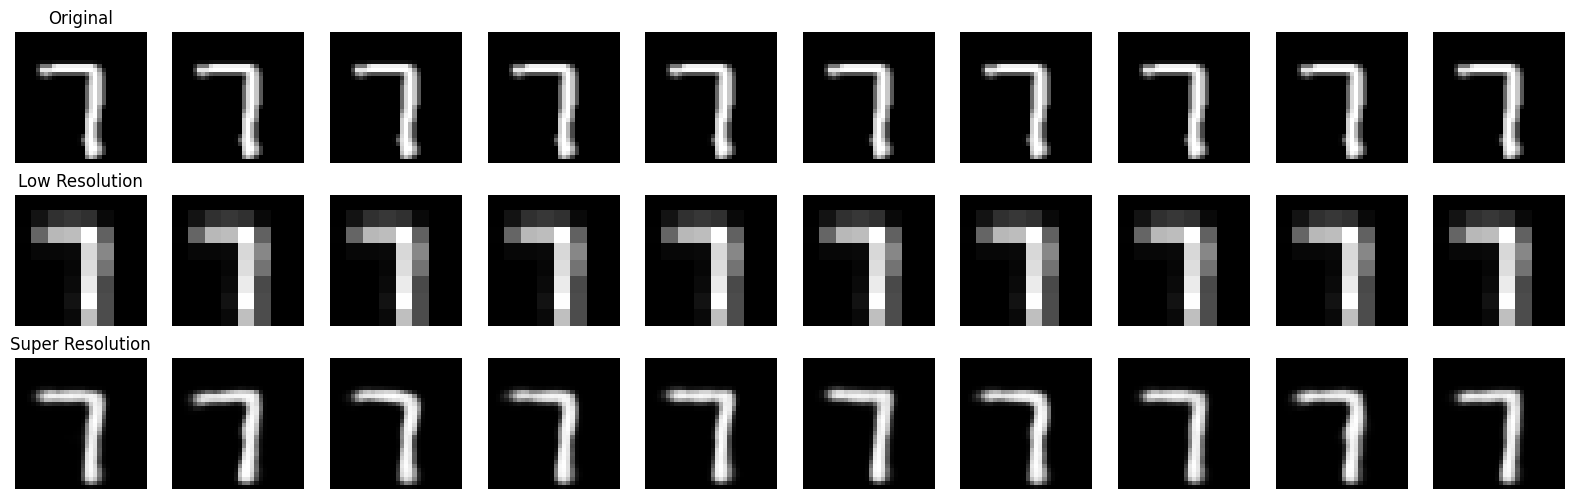

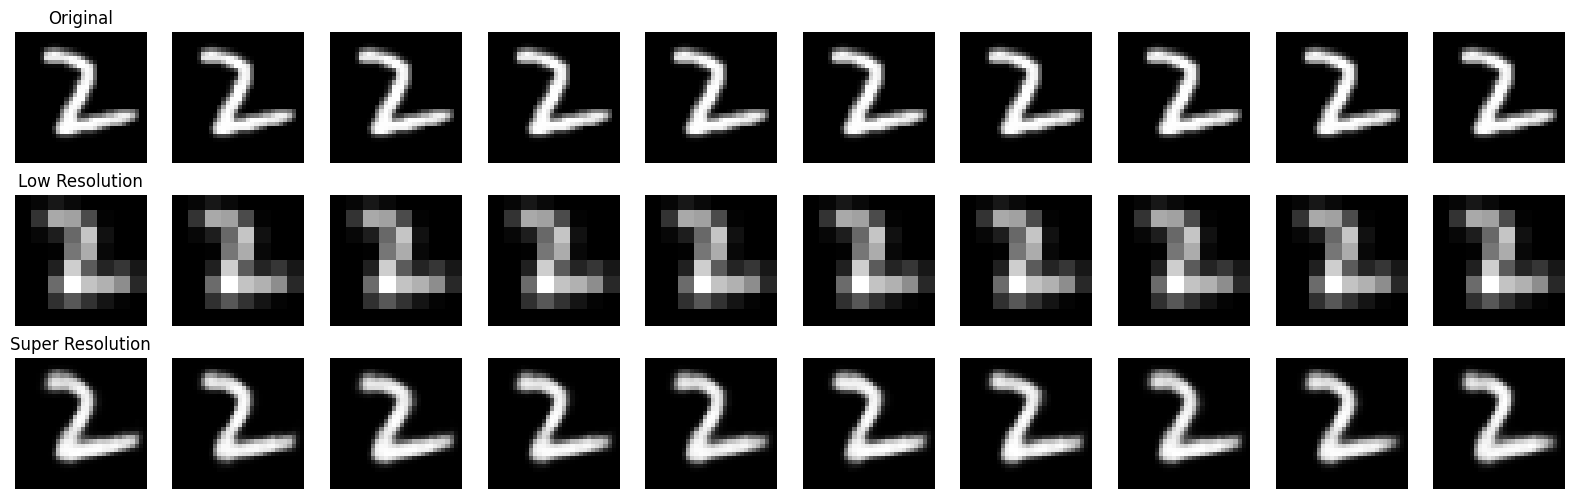

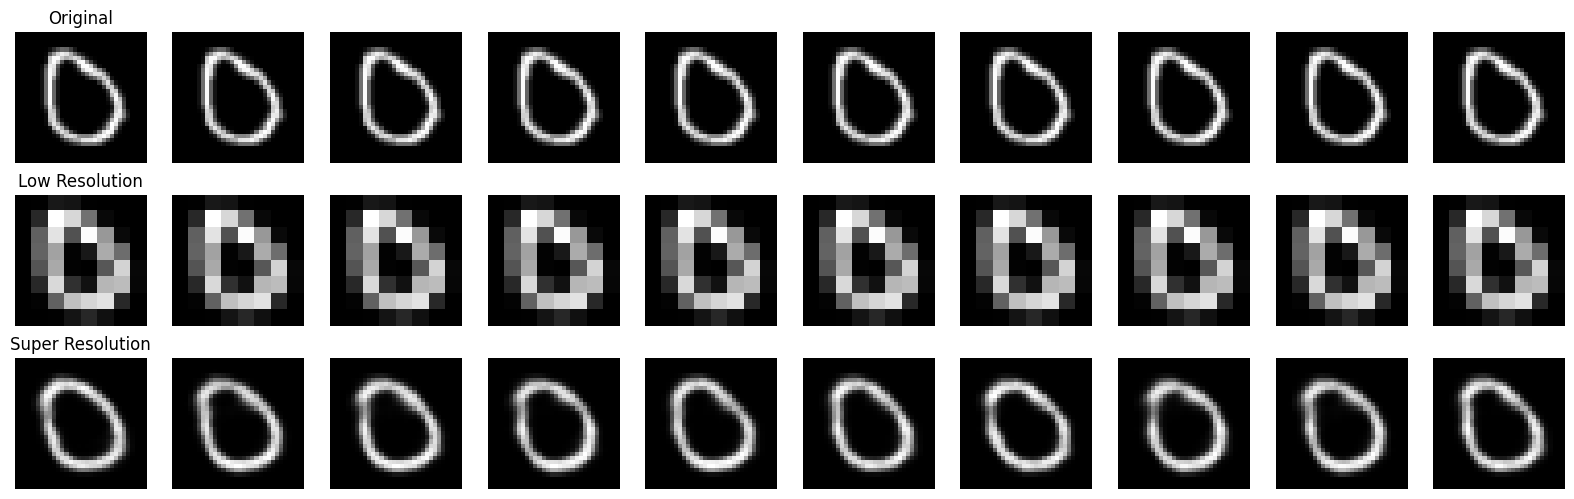

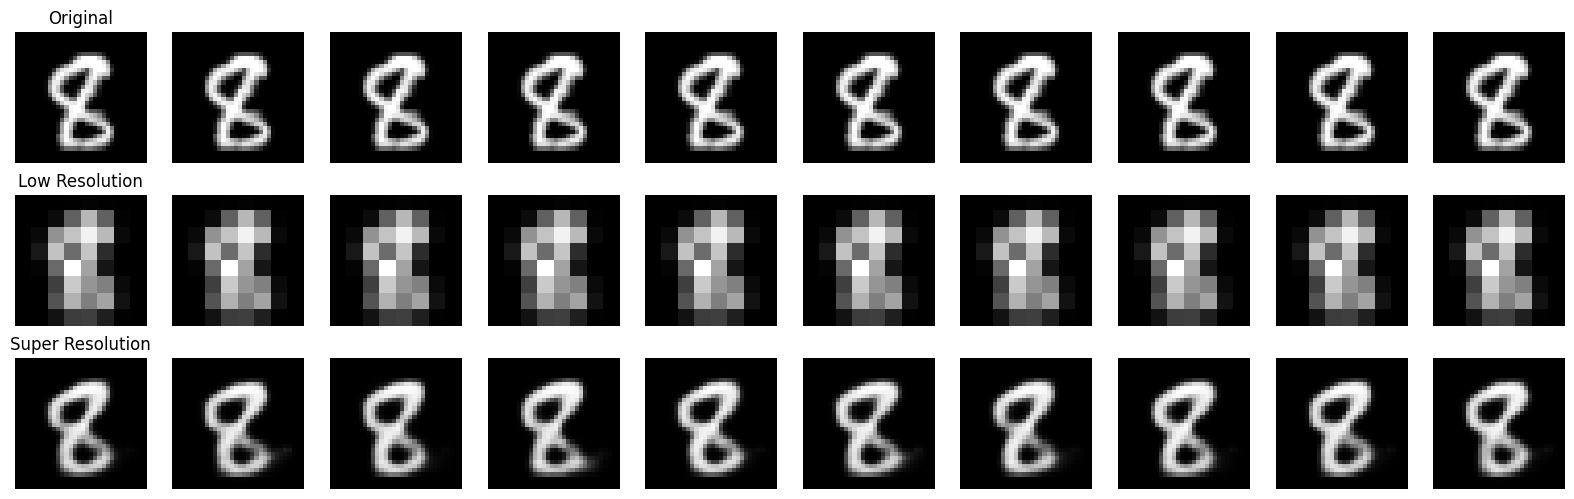

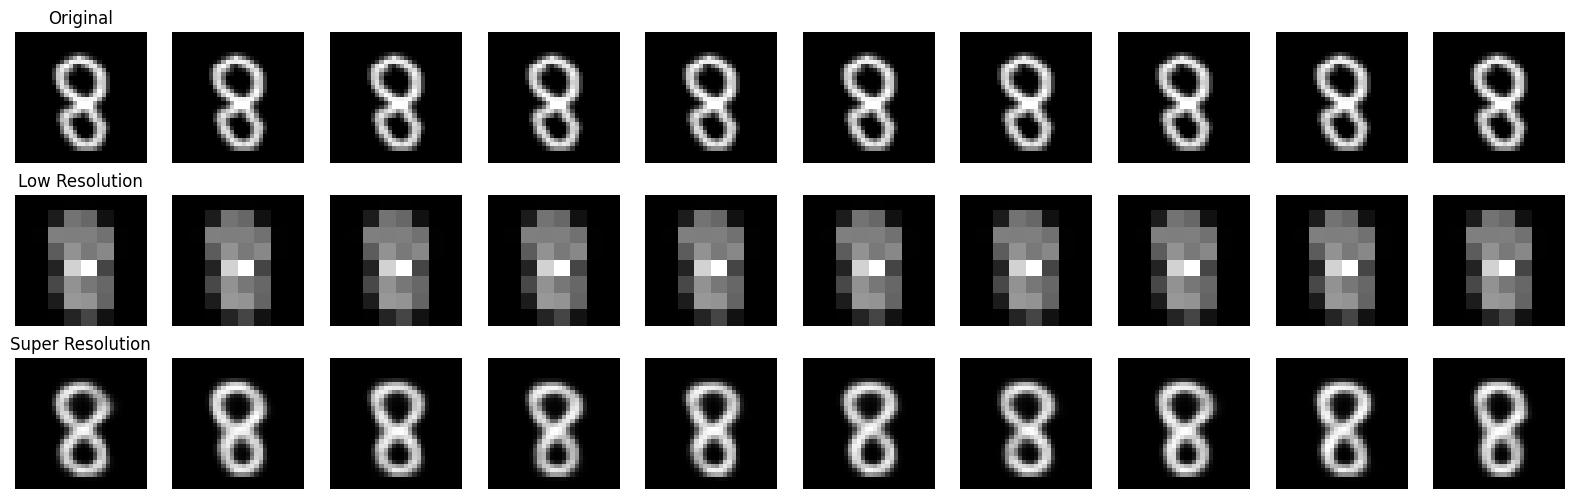

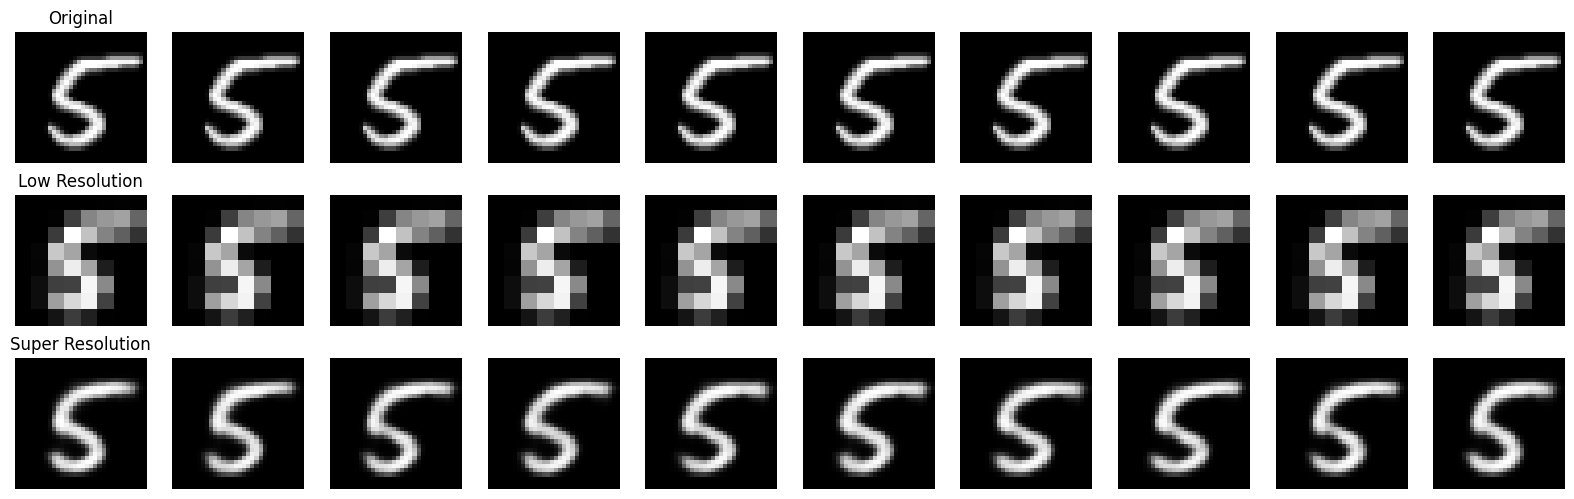

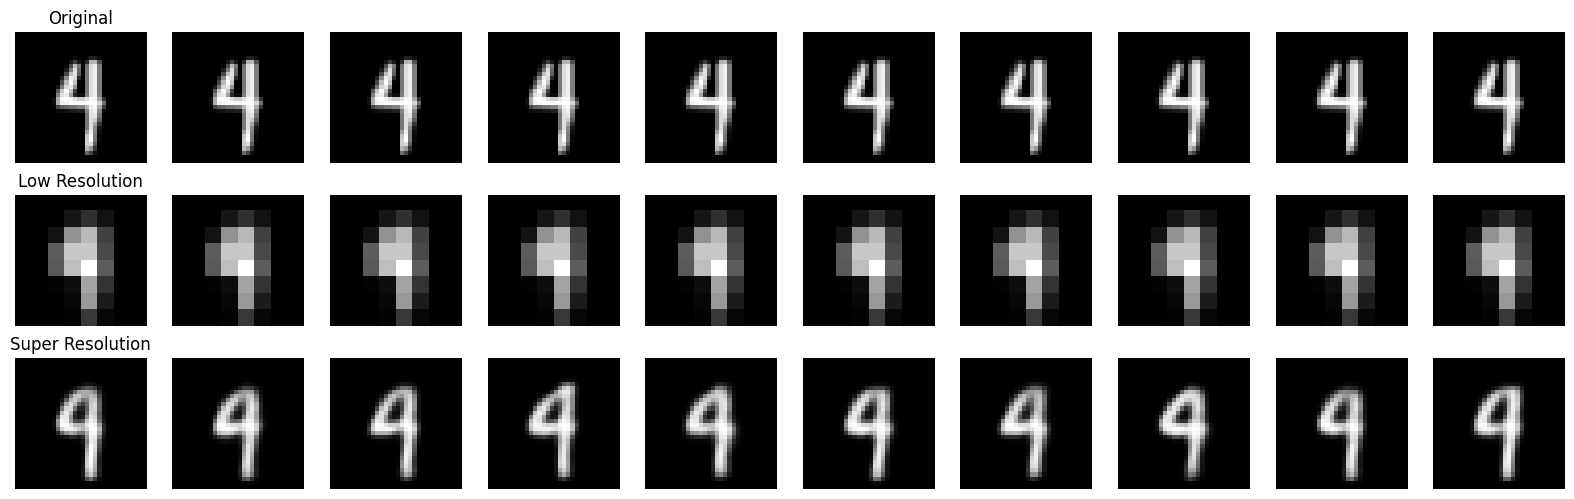

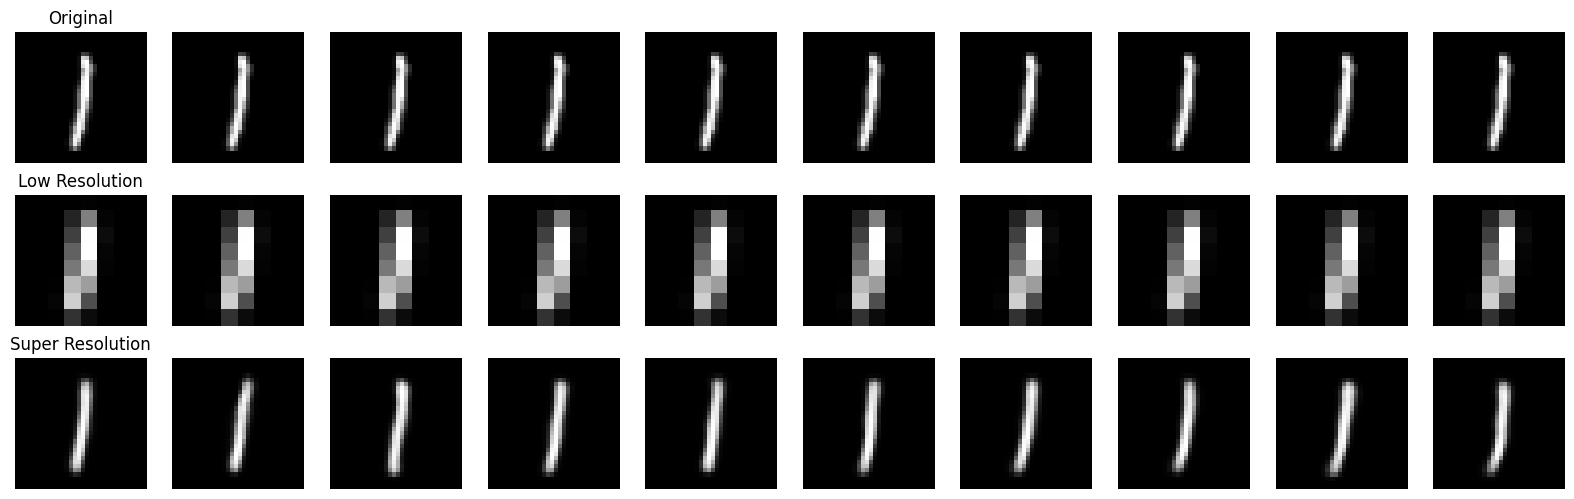

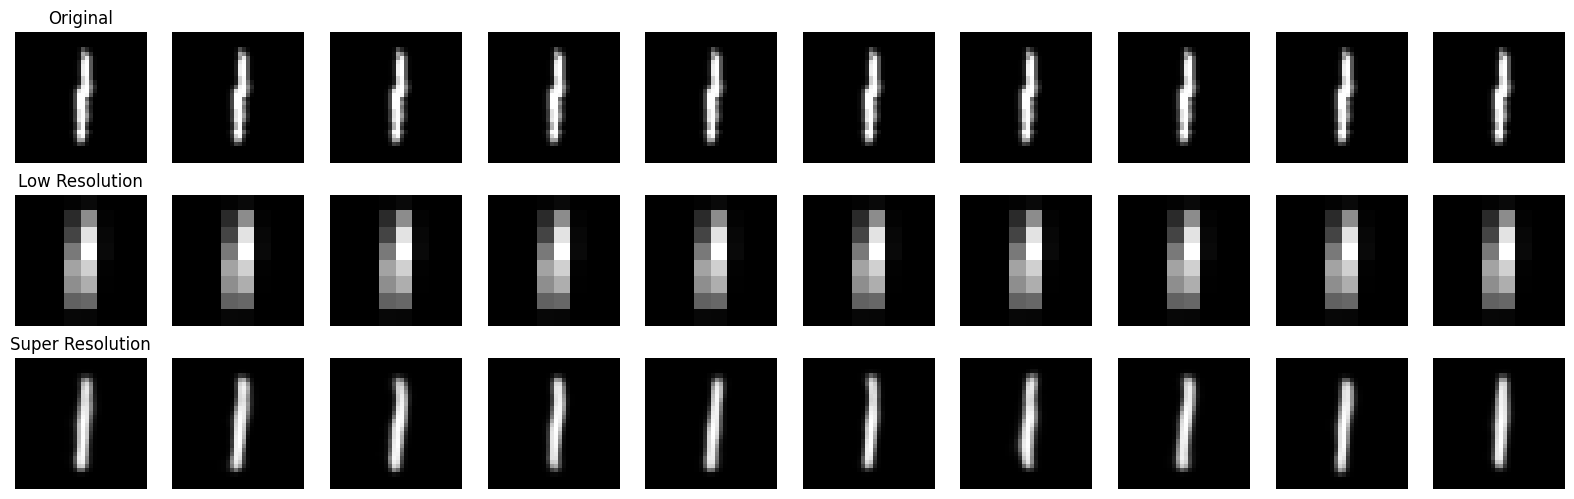

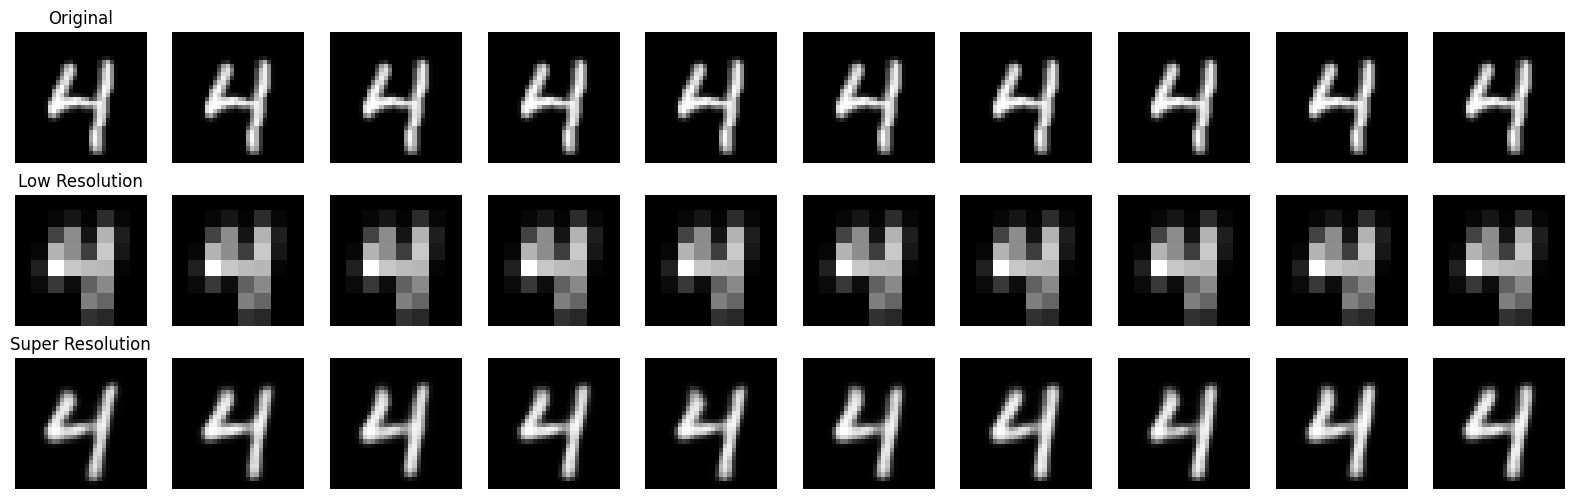

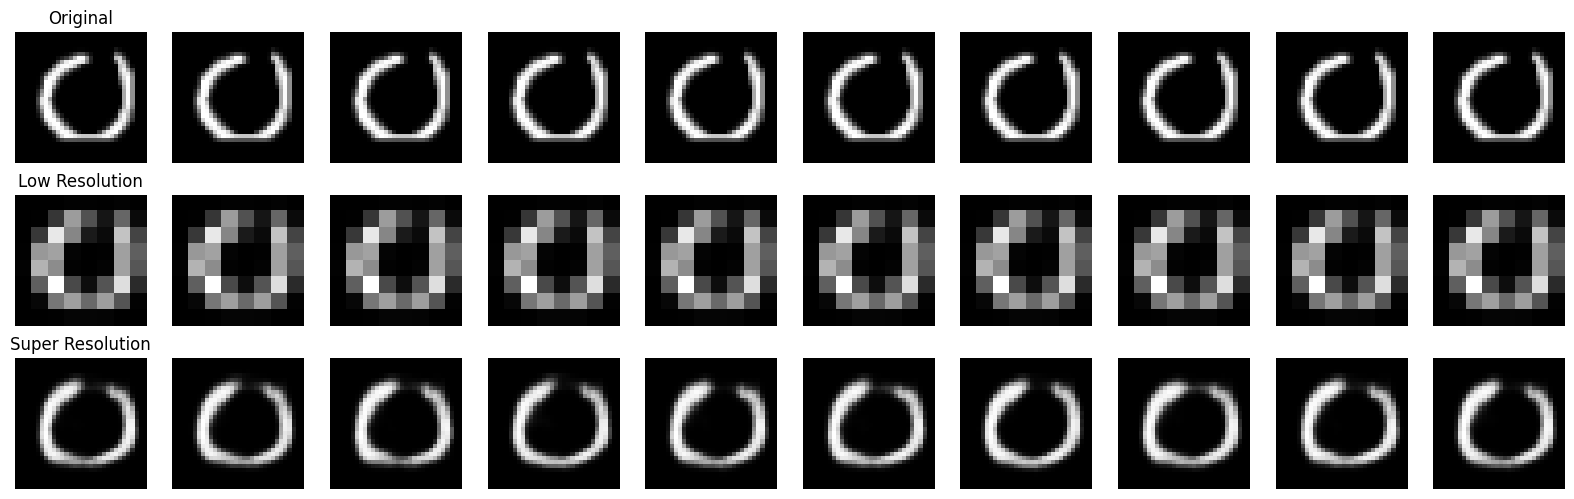

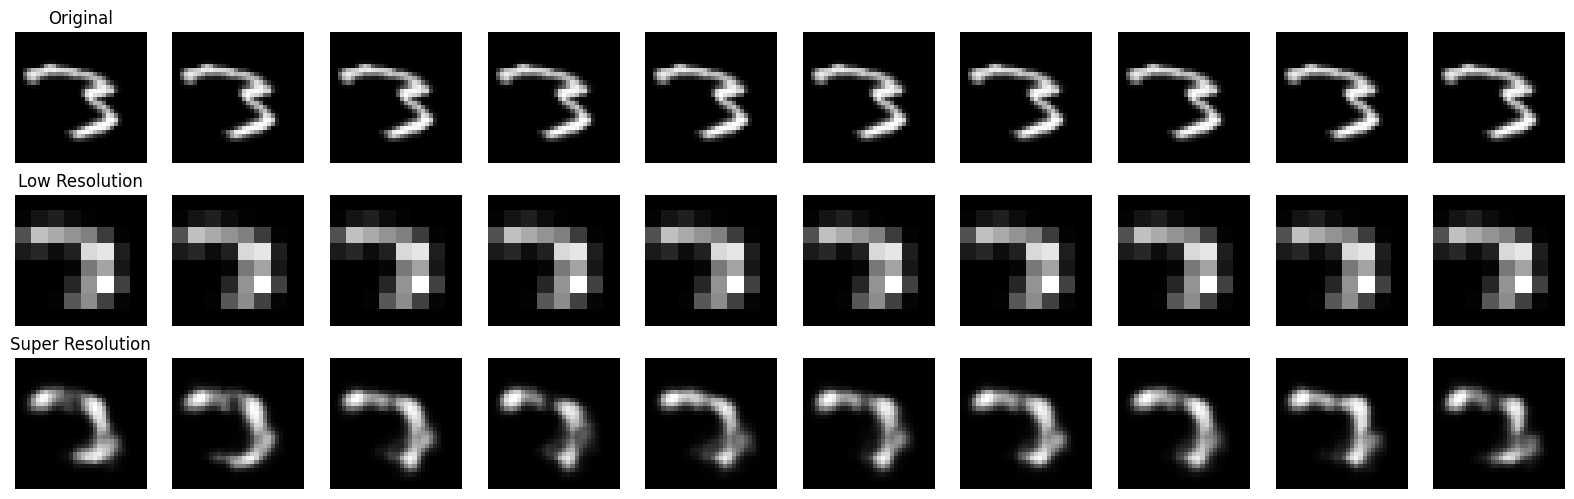

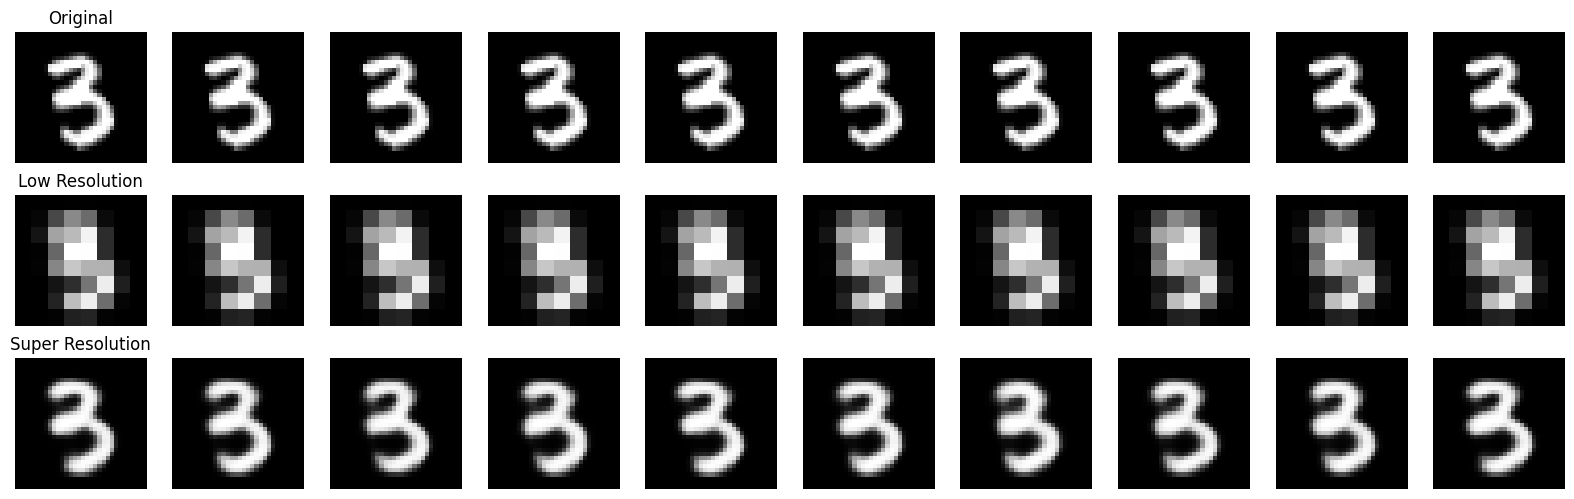

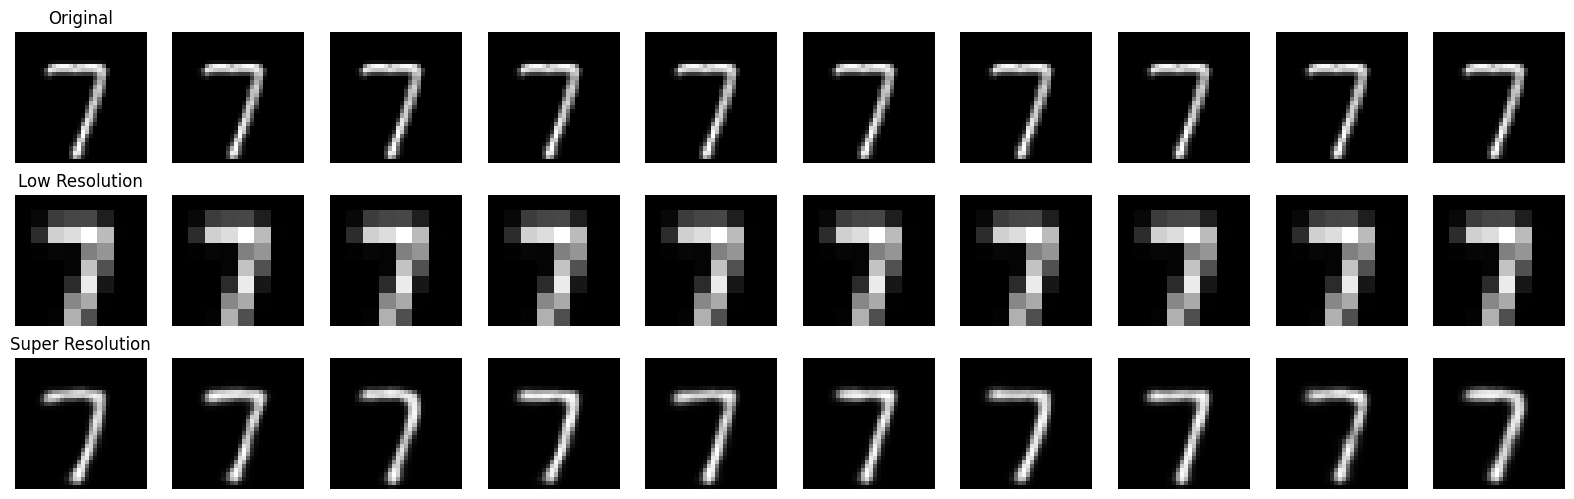

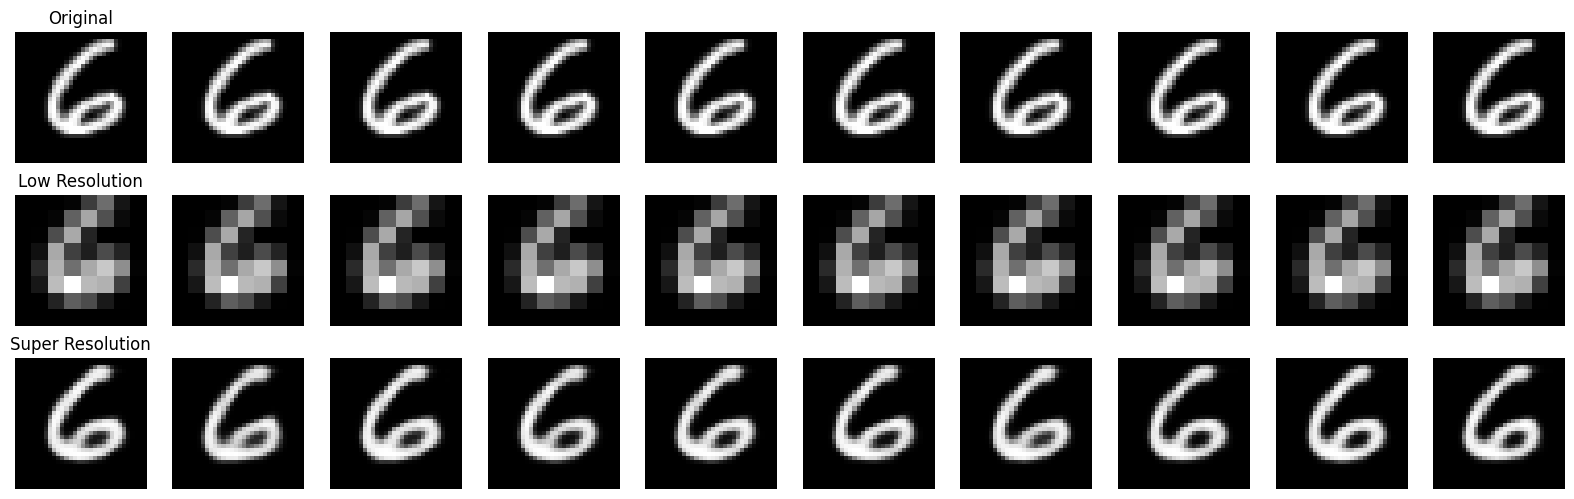

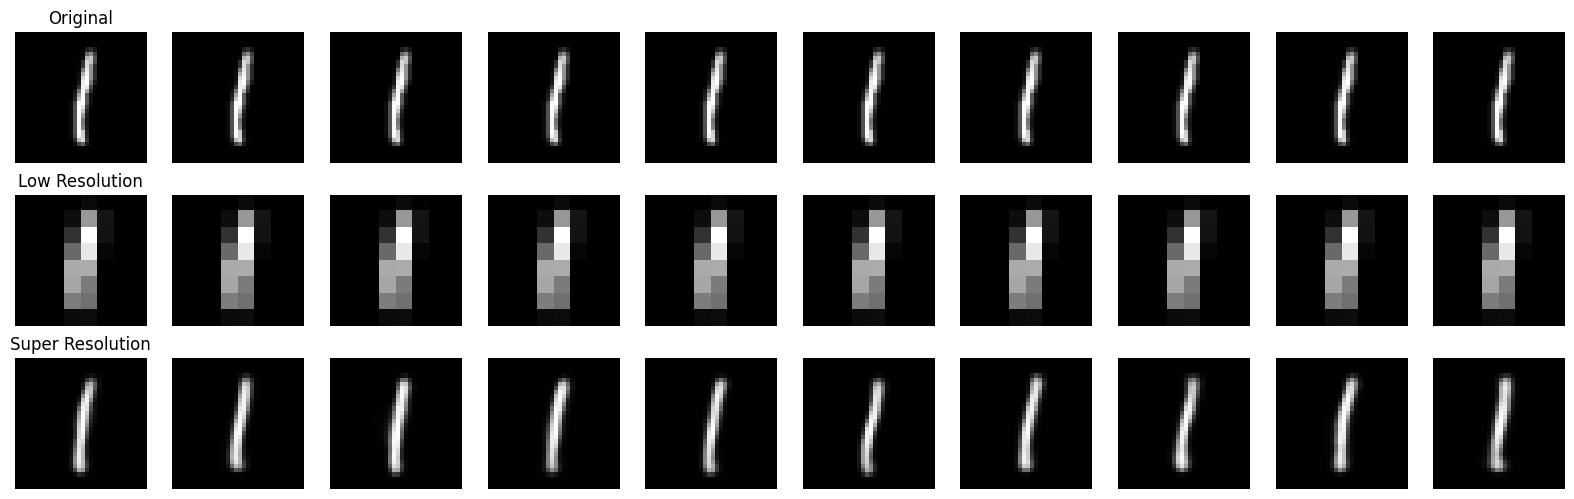

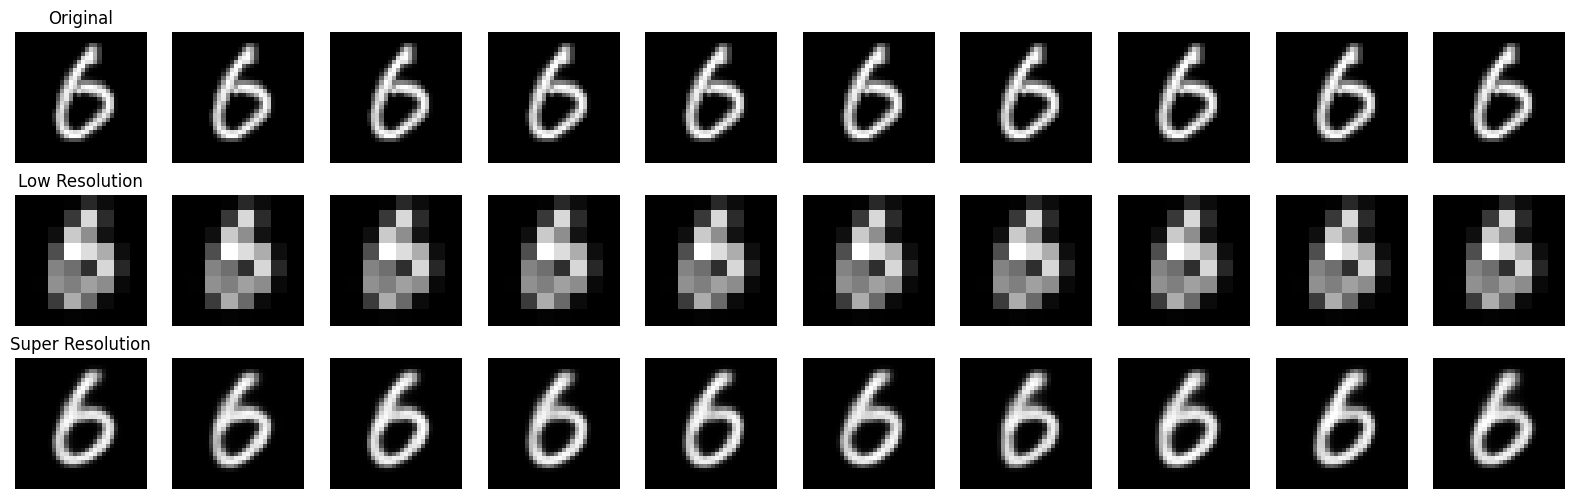

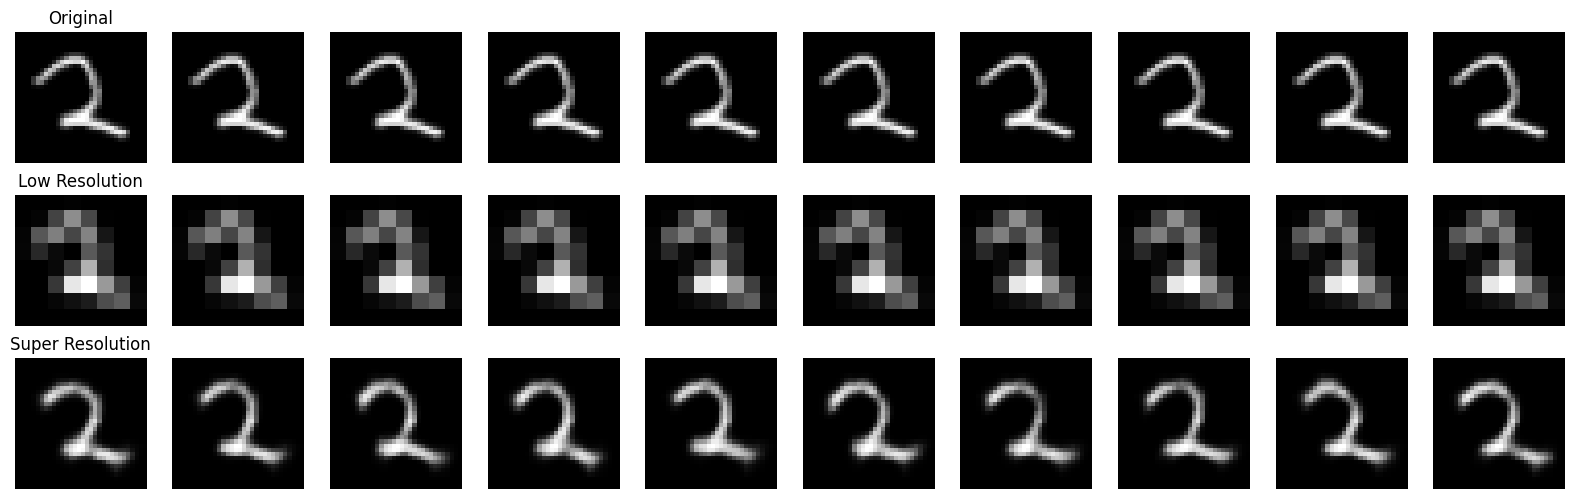

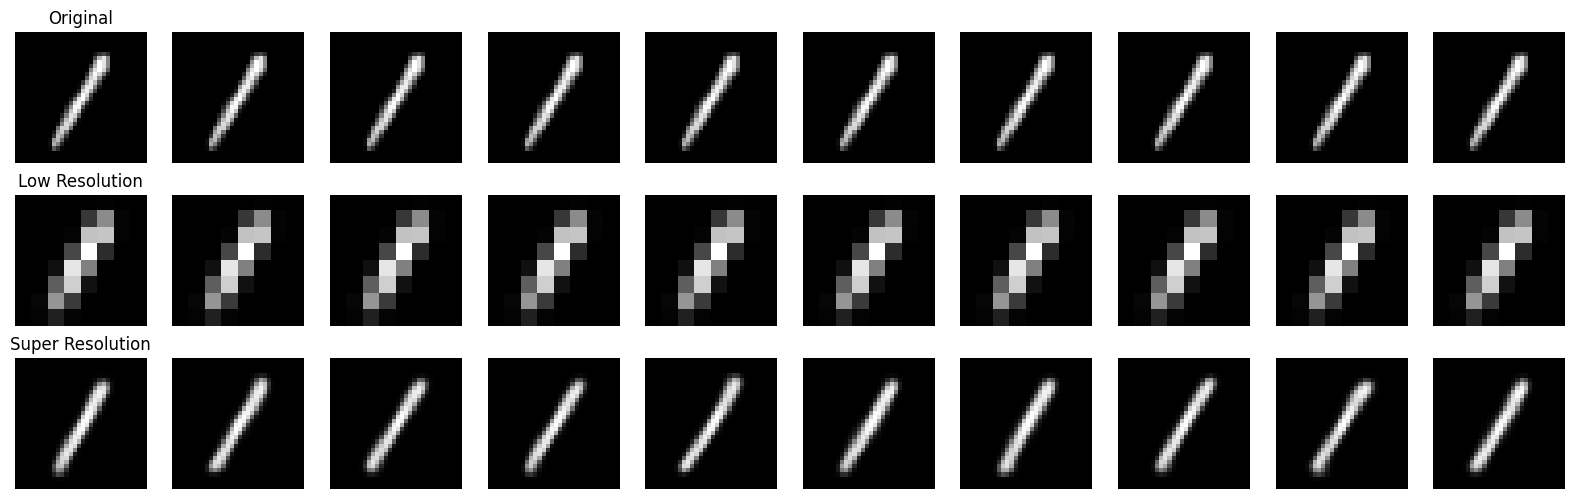

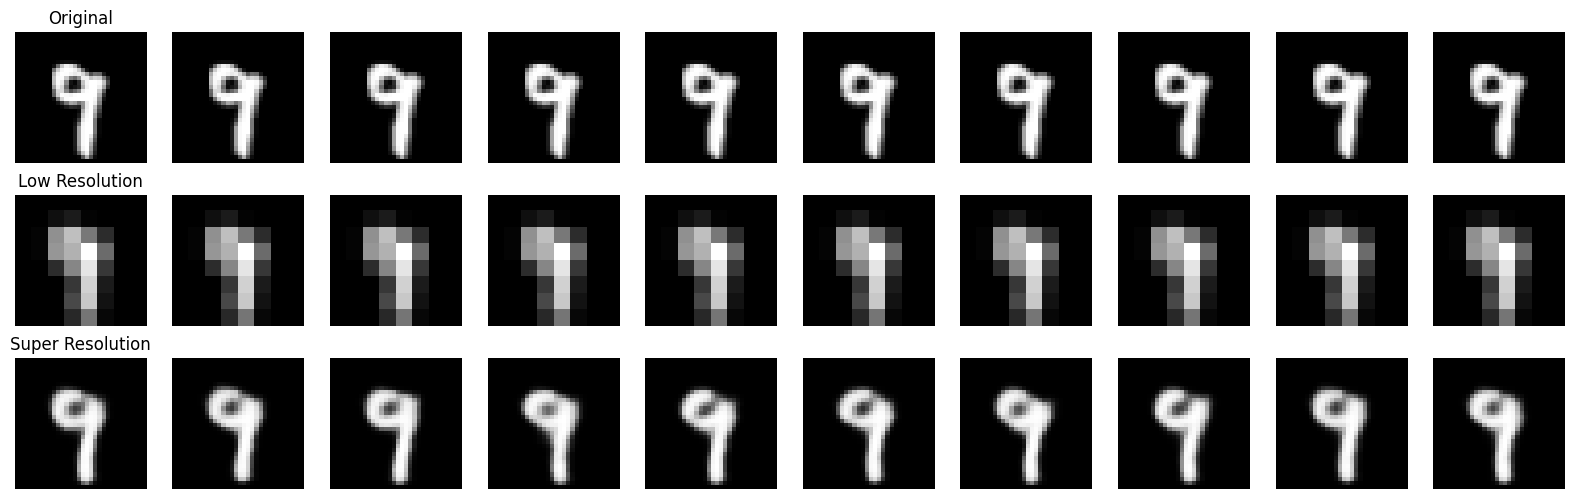

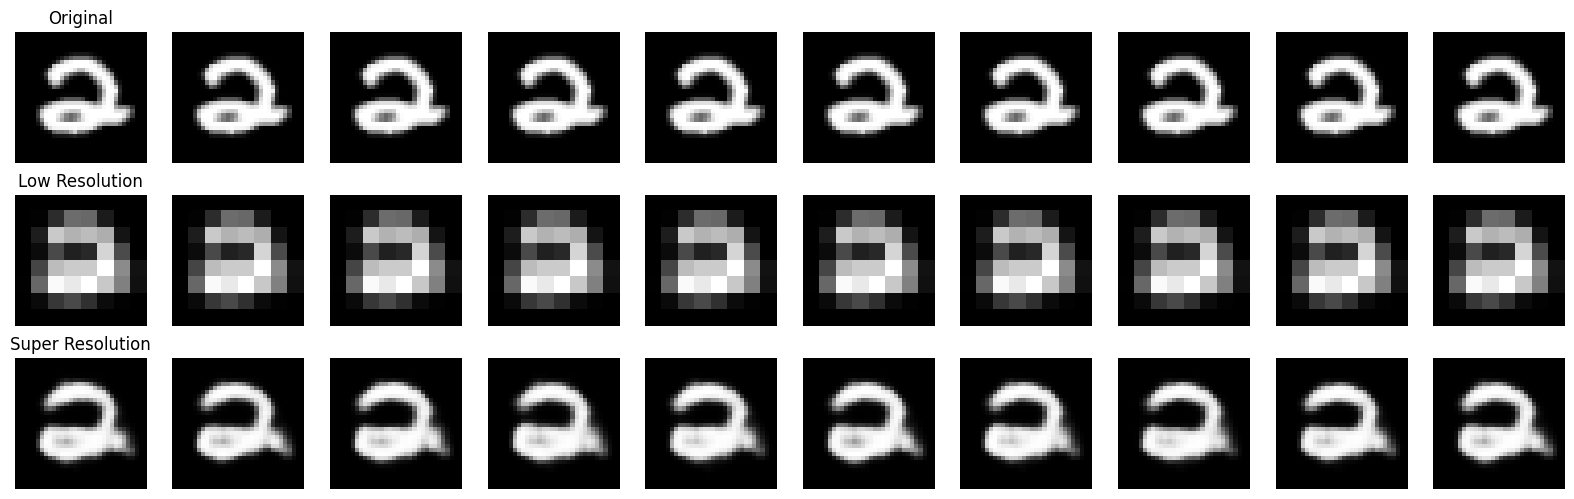

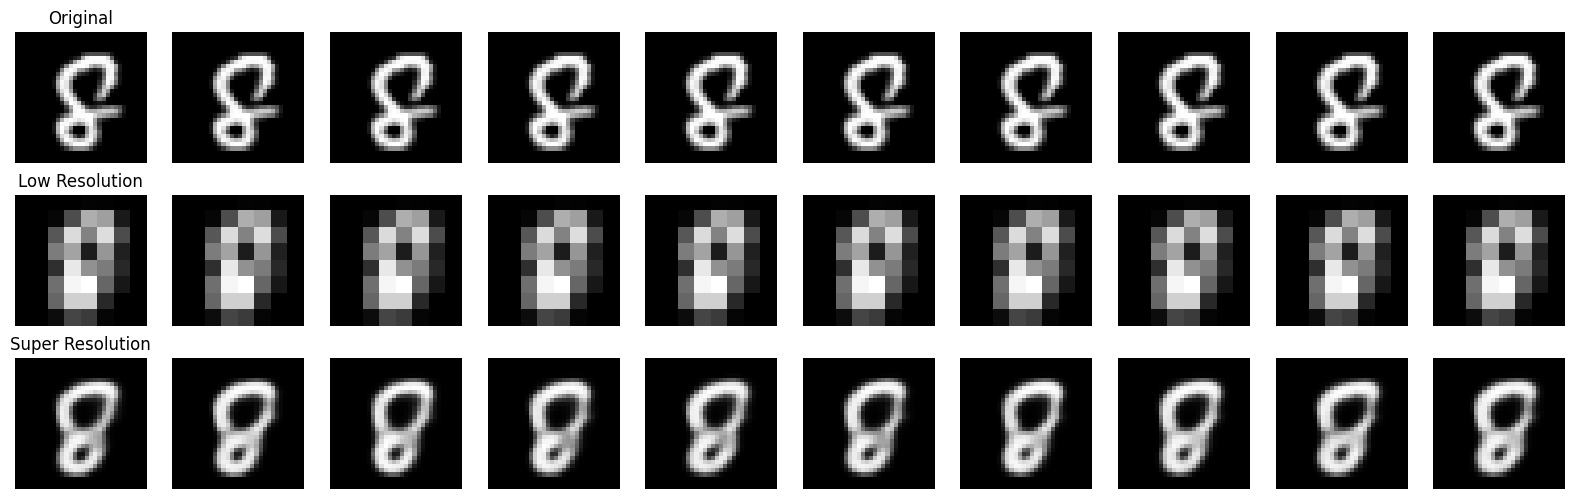

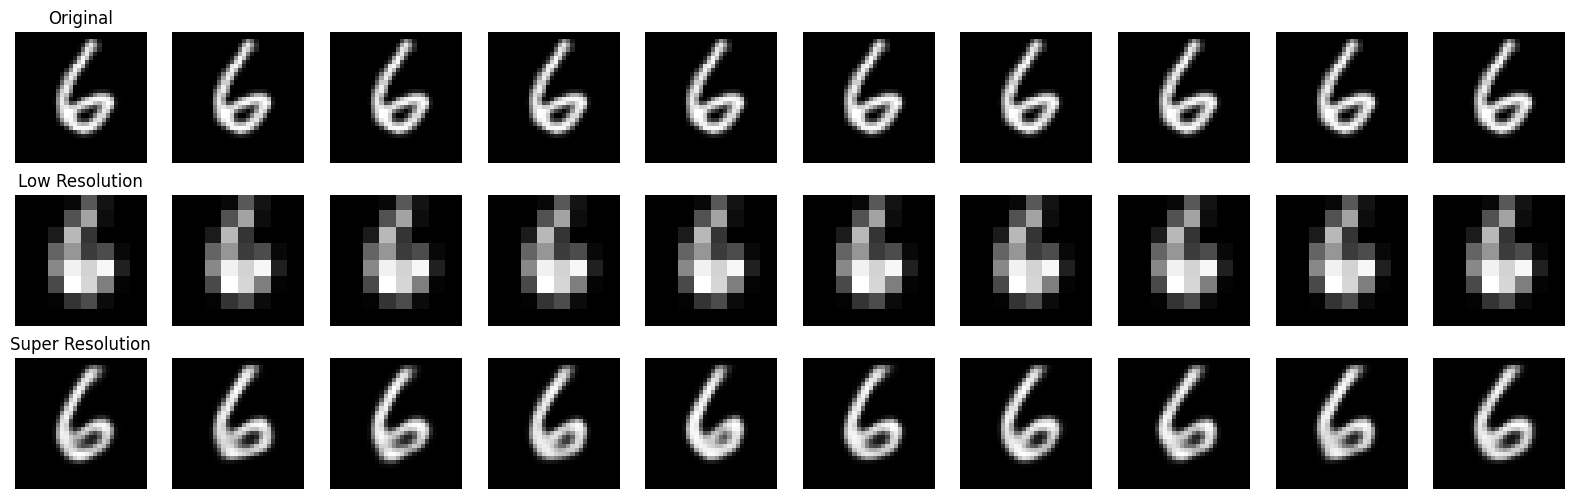

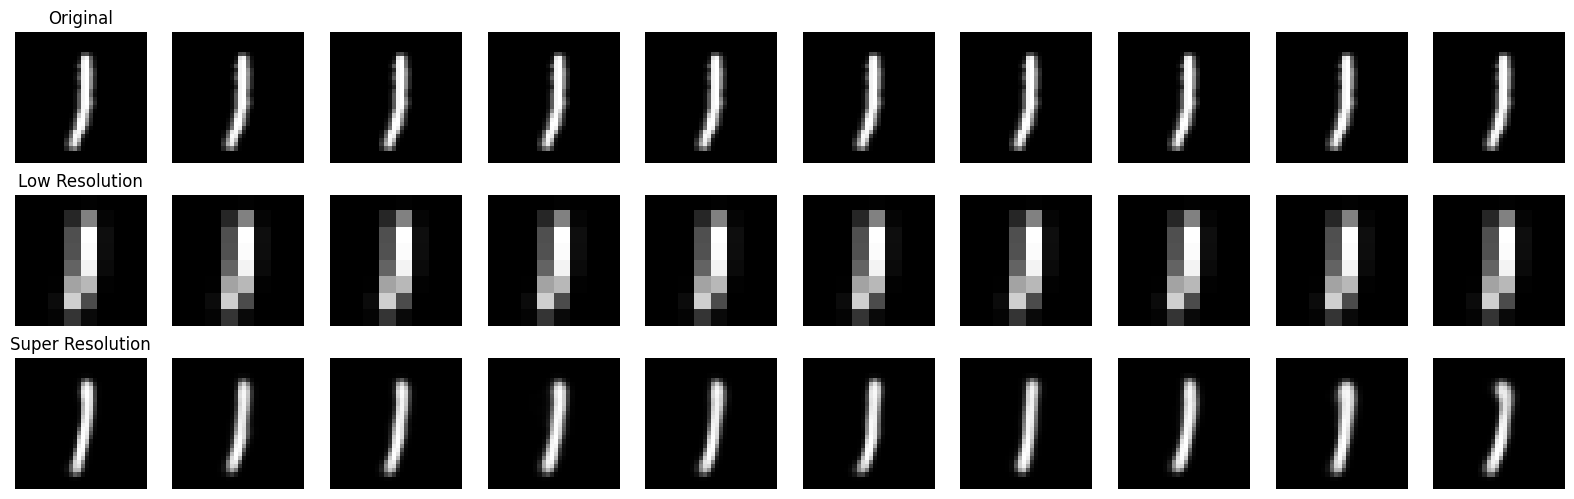

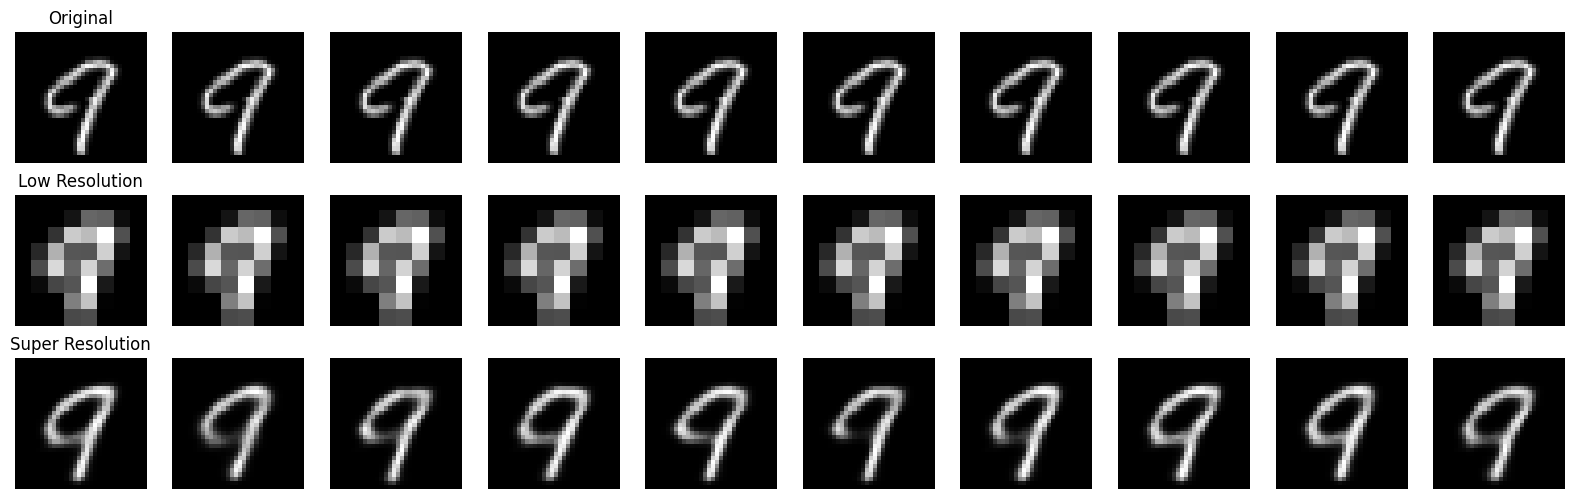

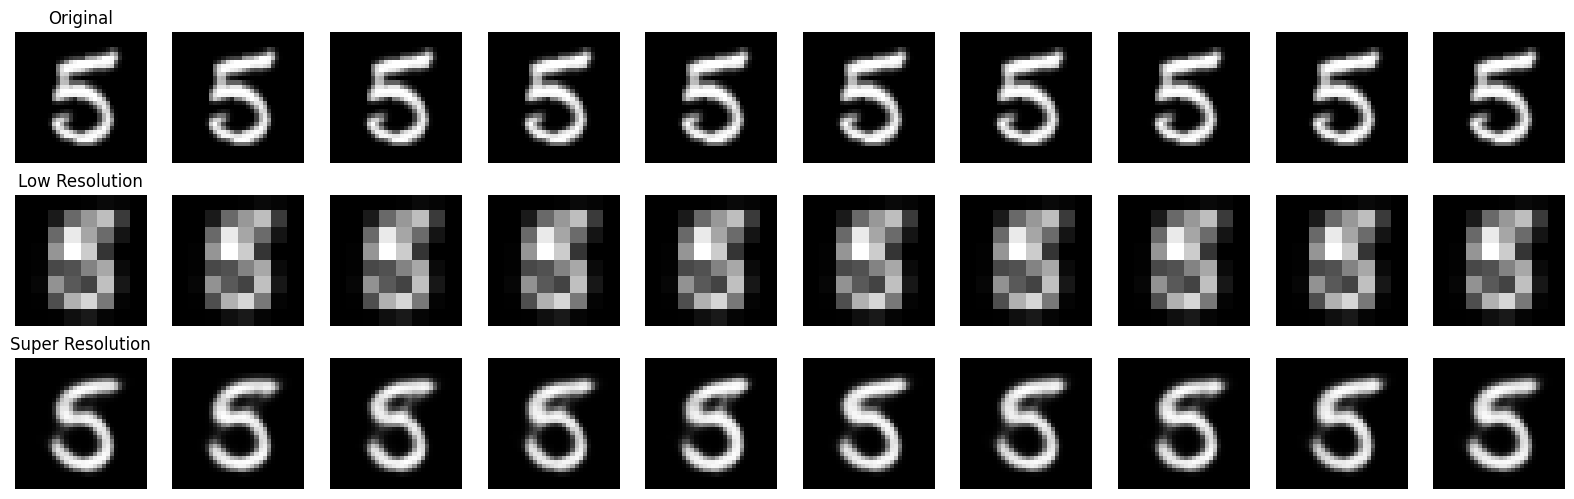

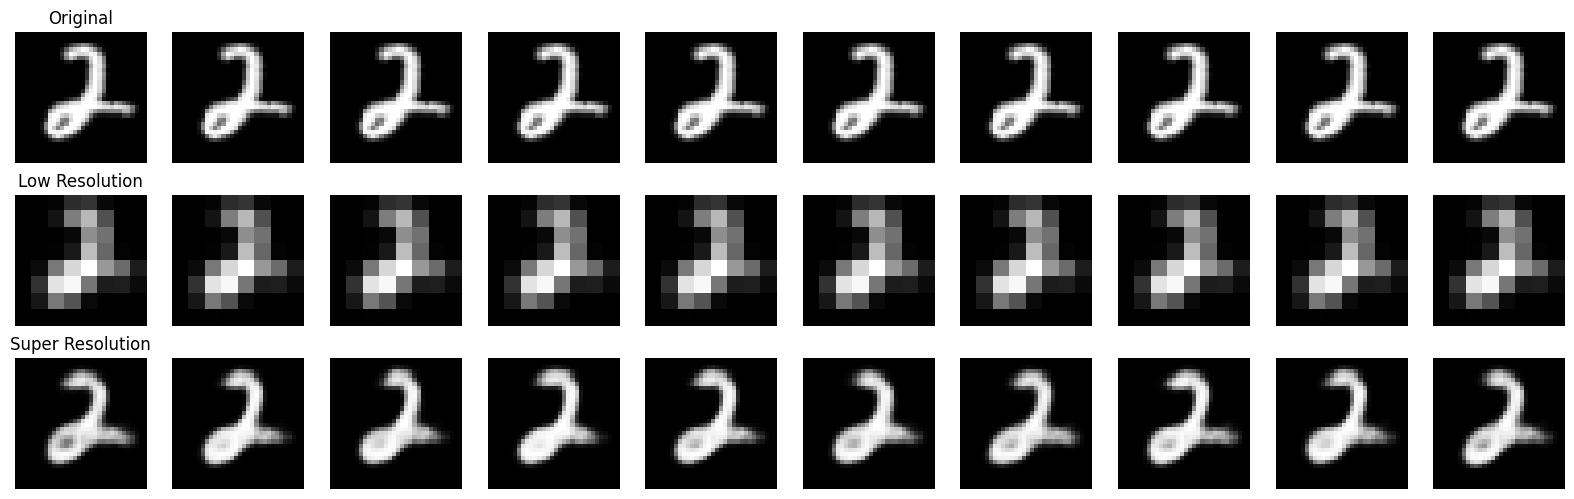

In [117]:
n_samp = 30
offset = 367
#40

for i in range(offset, offset +n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = vae_model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

Text(0.5, 1.0, '        Super Resolution VAE')

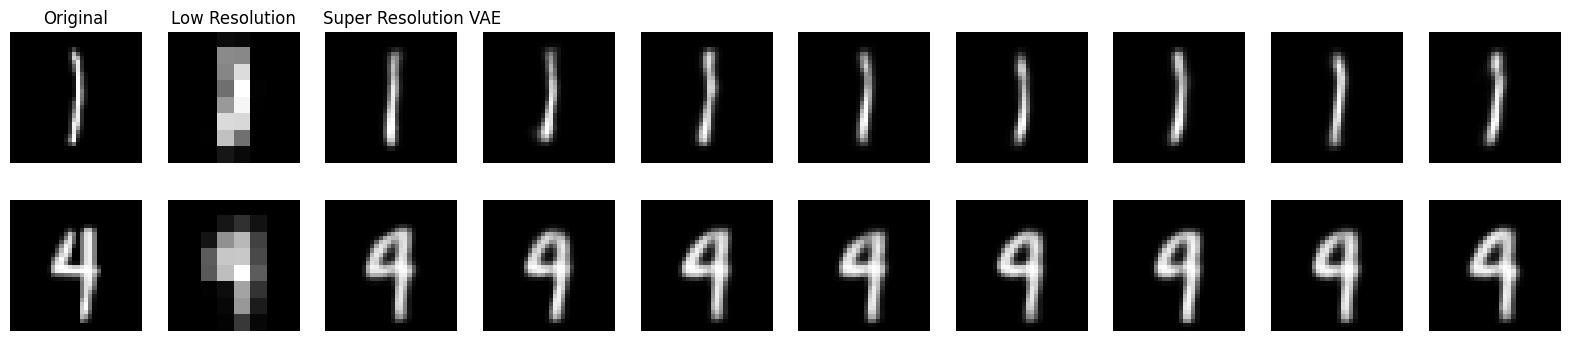

In [121]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

i = 40
reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
reference_x = HR[i]
samples_vae = vae_model.sample(reference_inp)

axs[0, 0].imshow(reference_x.permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[0, 0].axis('off')

axs[0, 1].imshow(reference_inp[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[0, 1].axis('off')

for j in range(2, 10):
    axs[0, j].imshow(samples_vae[j].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
    axs[0, j].axis('off')

i = 367 +9
reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
reference_x = HR[i]
samples_vae = vae_model.sample(reference_inp)

axs[1, 0].imshow(reference_x.permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[1, 0].axis('off')

axs[1, 1].imshow(reference_inp[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[1, 1].axis('off')

for j in range(2, 10):
    axs[1, j].imshow(samples_vae[j].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
    axs[1, j].axis('off')

axs[0, 0].set_title('Original')
axs[0, 1].set_title('Low Resolution')
axs[0, 2].set_title('        Super Resolution VAE')




Text(0.5, 1.0, '        Super Resolution HVAE')

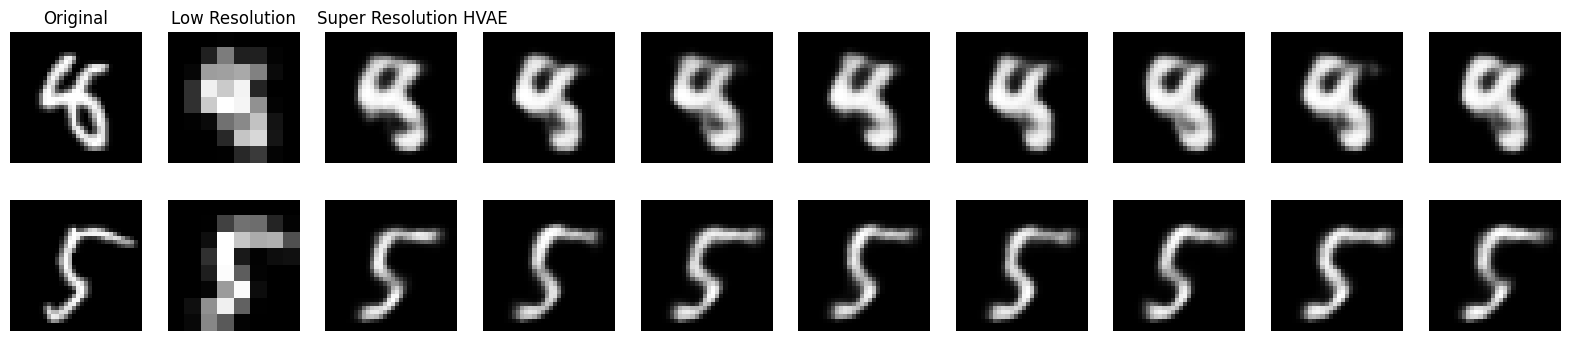

In [85]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

i = -7 + 30 + 267
reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
reference_x = HR[i]
samples_hvae = hvae_model.sample(reference_inp)

axs[0, 0].imshow(reference_x.permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[0, 0].axis('off')

axs[0, 1].imshow(reference_inp[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[0, 1].axis('off')

for j in range(2, 10):
    axs[0, j].imshow(samples_hvae[j].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
    axs[0, j].axis('off')


i = 767+12
reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
reference_x = HR[i]
samples_hvae = hvae_model.sample(reference_inp)

axs[1, 0].imshow(reference_x.permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[1, 0].axis('off')

axs[1, 1].imshow(reference_inp[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[1, 1].axis('off')

for j in range(2, 10):
    axs[1, j].imshow(samples_hvae[j].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
    axs[1, j].axis('off')

axs[0, 0].set_title('Original')
axs[0, 1].set_title('Low Resolution')
axs[0, 2].set_title('        Super Resolution HVAE')

Text(0.5, 1.0, '        Super Resolution HVAE')

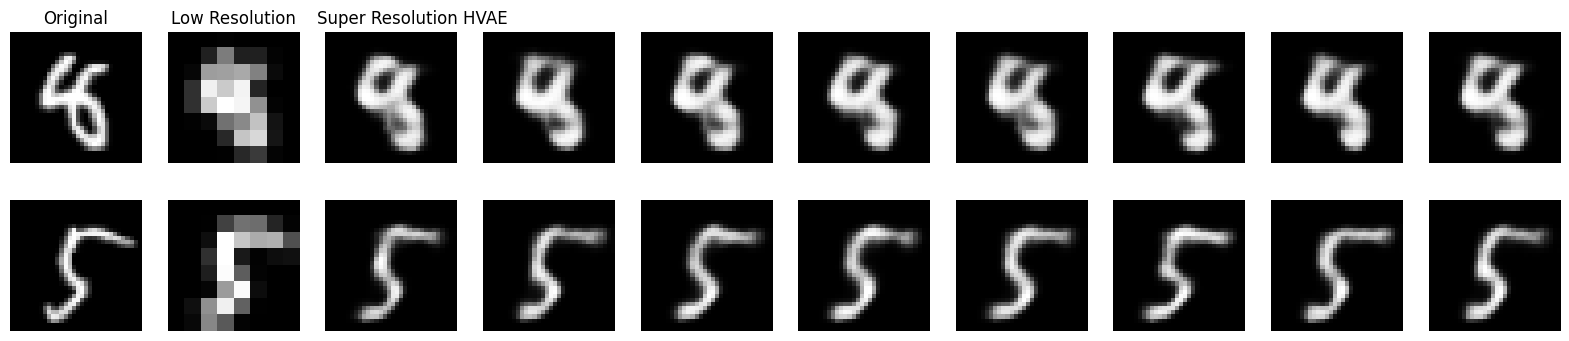

In [112]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

i = -7 + 30 + 267
reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
reference_x = HR[i]
samples_hvae = hvae_model.sample(reference_inp)

axs[0, 0].imshow(reference_x.permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[0, 0].axis('off')

axs[0, 1].imshow(reference_inp[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[0, 1].axis('off')

for j in range(2, 10):
    axs[0, j].imshow(samples_hvae[j].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
    axs[0, j].axis('off')


i = 767+12
reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
reference_x = HR[i]
samples_hvae = hvae_model.sample(reference_inp)

axs[1, 0].imshow(reference_x.permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[1, 0].axis('off')

axs[1, 1].imshow(reference_inp[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
axs[1, 1].axis('off')

for j in range(2, 10):
    axs[1, j].imshow(samples_hvae[j].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
    axs[1, j].axis('off')

axs[0, 0].set_title('Original')
axs[0, 1].set_title('Low Resolution')
axs[0, 2].set_title('        Super Resolution HVAE')

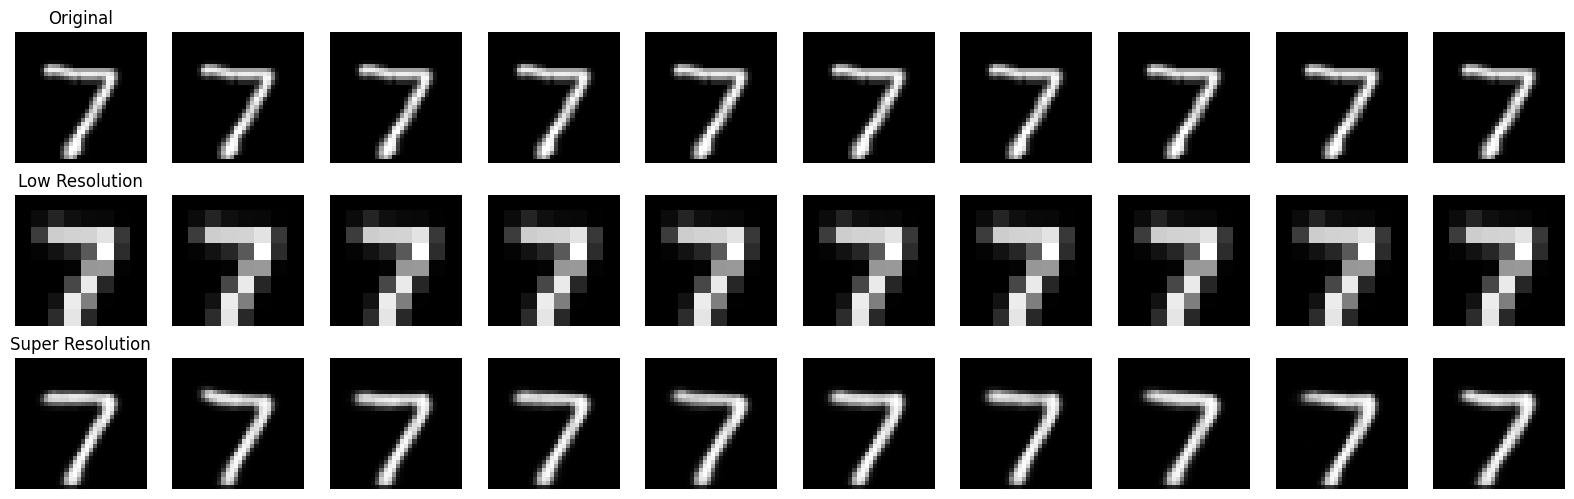

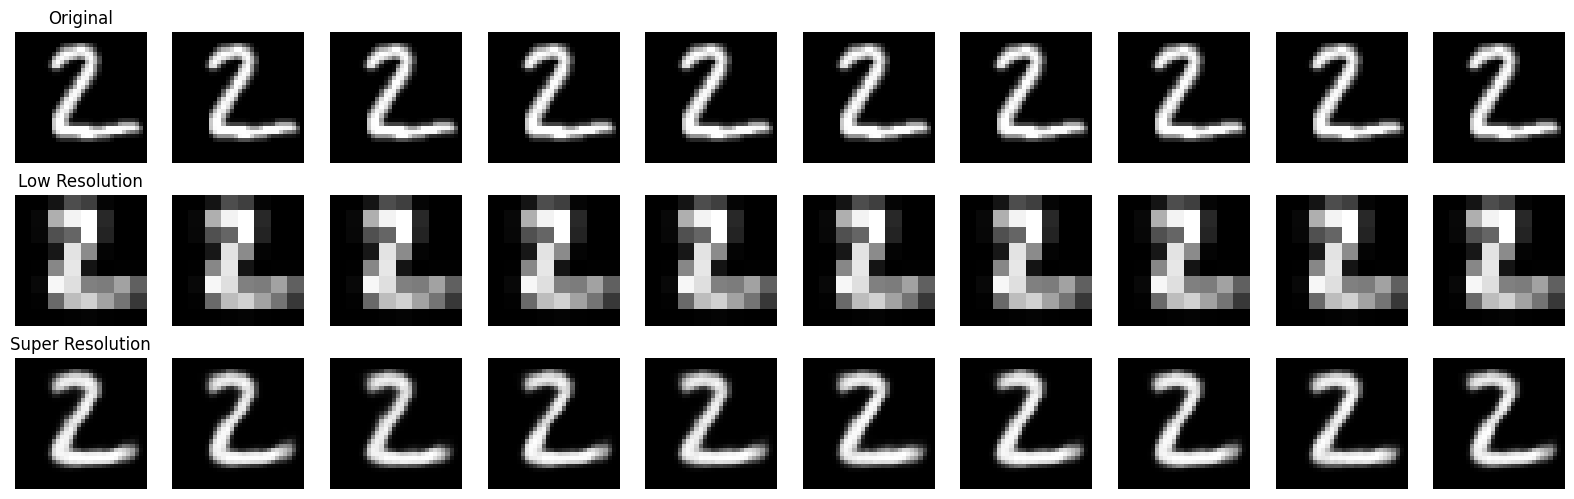

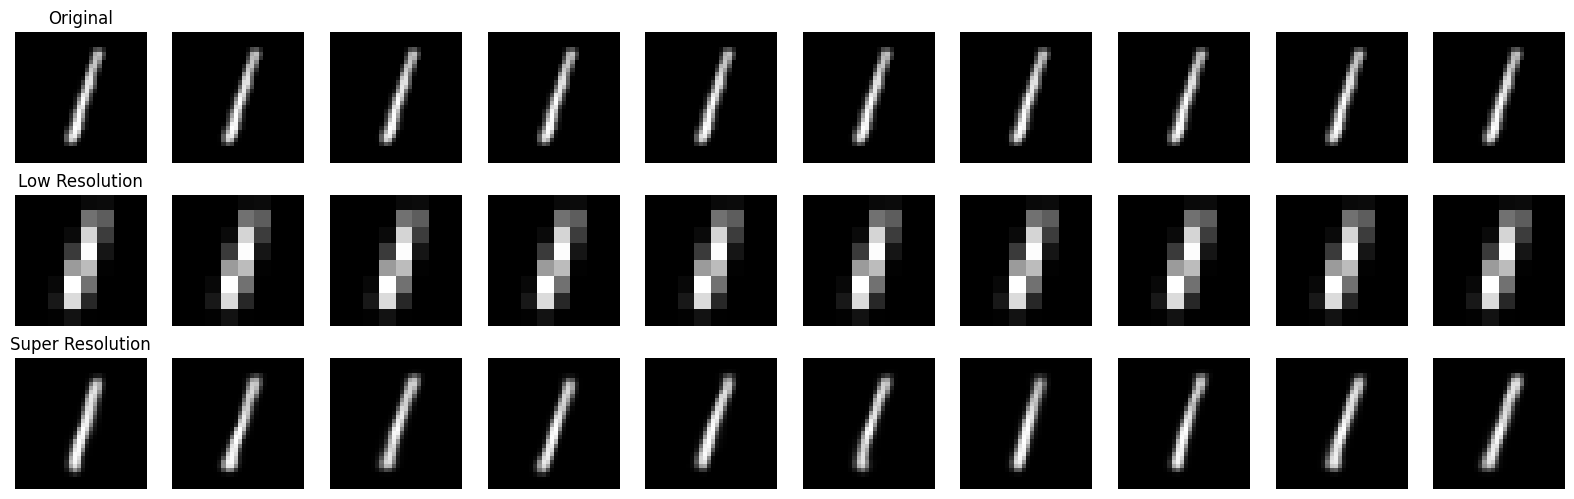

In [13]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = vae_model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

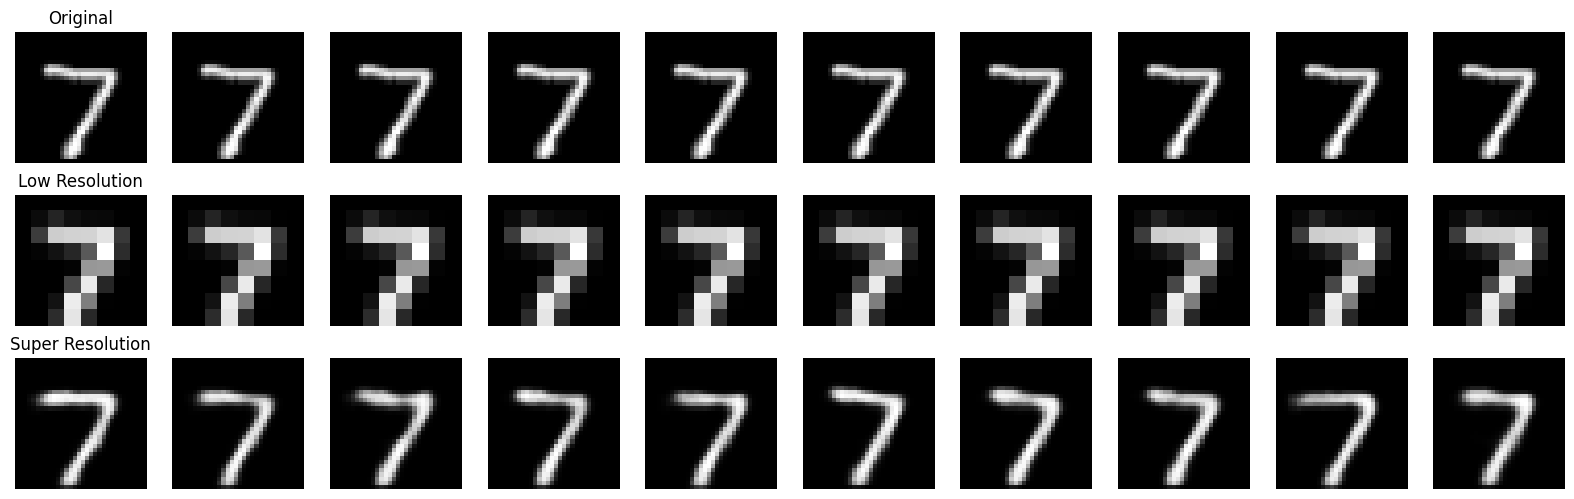

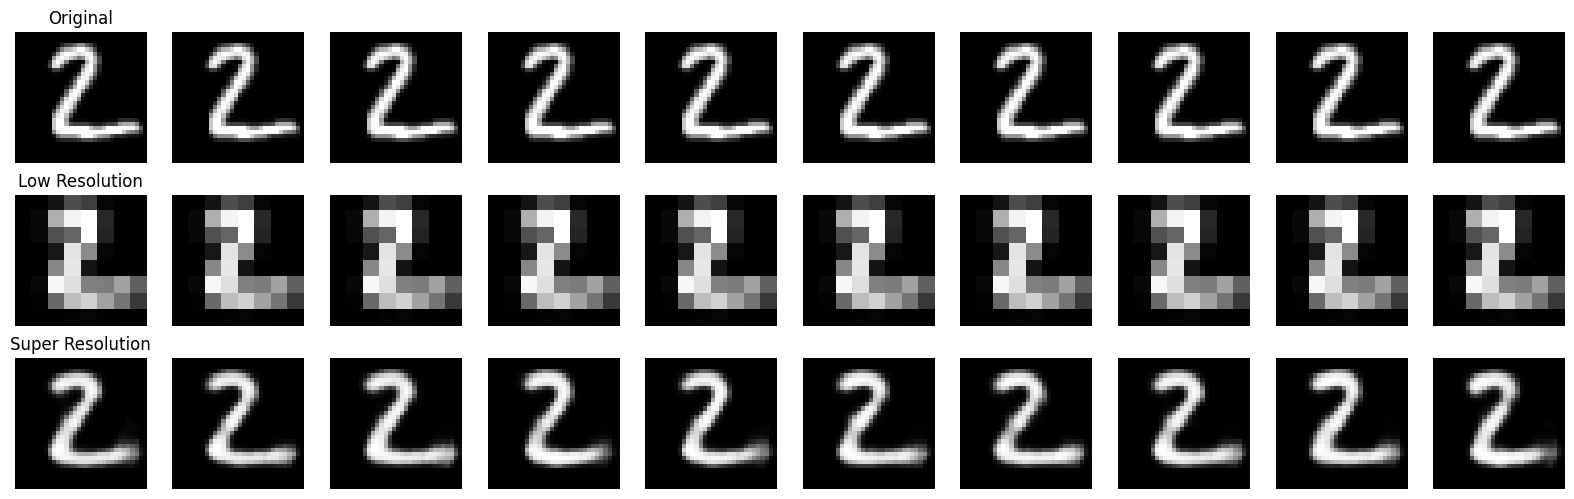

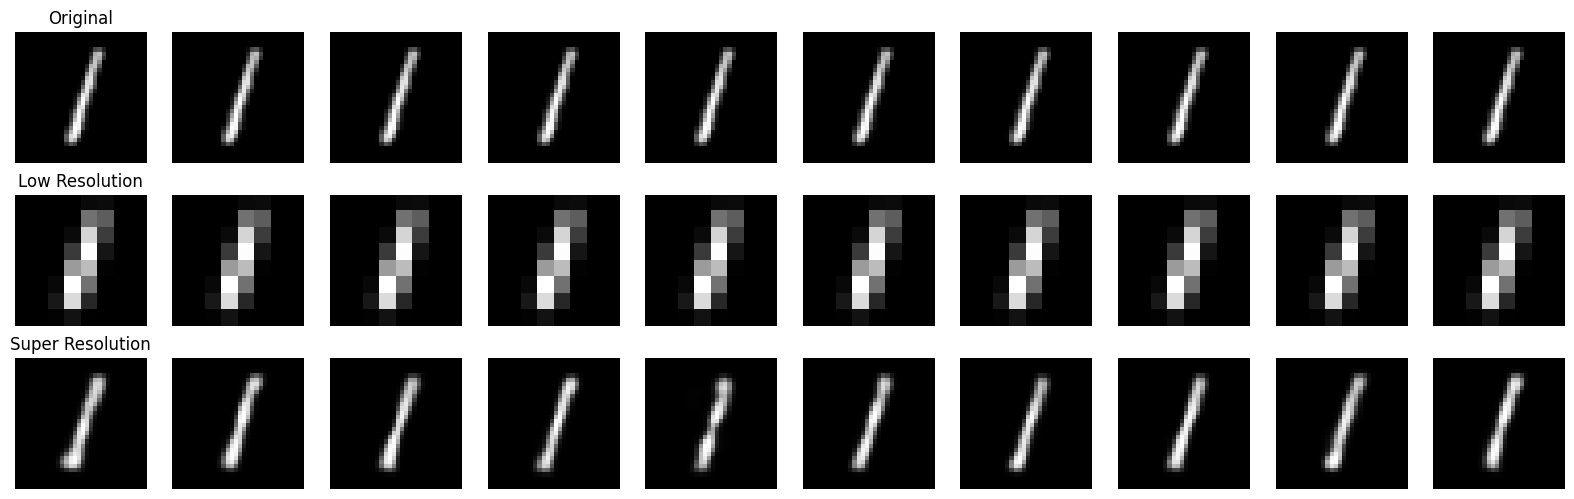

In [15]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = hvae_model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [16]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(vae_model, HR, LR)
print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 0.007306443527340889
Perceptual: 1.4588165283203125
PSNR: 22.095504760742188
SSIM: 0.8755830526351929
LPIPS: 0.06887330859899521
BRISQUE: 73.67166137695312
PSNR Consistency: 32.47934341430664
MSE Diversity: 0.0020238669205809856
LPIPS Diversity: 0.016547641382203437


In [17]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(hvae_model, HR, LR)
print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

MSE: 0.008200098760426044
Perceptual: 1.6067173480987549
PSNR: 21.496318817138672
SSIM: 0.8550634980201721
LPIPS: 0.07732045650482178
BRISQUE: 74.94895935058594
PSNR Consistency: 31.362167358398438
MSE Diversity: 0.0025742379880284716
LPIPS Diversity: 0.02255747559502197
